<a href="https://colab.research.google.com/github/Surojit-KB/UNIV-AI-AI3_Project/blob/main/Baseline_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#IMPORTING THE NECESSARY LIBRARIES
import re
import os
import json
import zipfile
import collections
import numpy as np
import pandas as pd
import urllib.request
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dot
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, SimpleRNN, Embedding, Dense, TimeDistributed,LSTM, GRU,Dropout, Bidirectional, Conv1D, BatchNormalization
from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.layers import Flatten
from sklearn.model_selection import train_test_split
from collections import Counter
from operator import itemgetter
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
#INSTALLING THE SENTENCEPIECE LIBRARY FOR SENTENCEPIECE TOKENIZER
!pip install sentencepiece
import sentencepiece as spm

     |████████████████████████████████| 1.2MB 25.4MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Getting the data and preprocessing
The SQUAD dataset is in the form of a JSON file, hence we need to load it manually into a dataframe. This part of the notebook focuses on loading the dataframe, preprocessing the data and getting the context text ready for tokenization.

In [5]:
#THIS IS THE CODE TO PREPROCESS THE SQUAD DATASET AND CREATE A DATAFRAME OUT OF IT
def get_dataframe(file):
  f = open(file, 'r')
  #loading json file 
  data = json.loads(f.read())
  #creating empty lists to store df values 
  iid = []
  tit = []
  con = []
  que = []
  ans = []
  txt = []
  #root tags contains 'title' tag and 'paragraphs' list 
  for i in range(len(data['data'])):
    title = data['data'][i]['title']
    #'paragraphs' list contains 'context' tag and 'qas' list 
    for p in range(len(data['data'][i]['paragraphs'])):
      context = data['data'][i]['paragraphs'][p]['context']
      for q in range(len(data['data'][i]['paragraphs'][p]['qas'])):
        # 'qas'list contains 'question', 'Id' tag and 'answers' list 
        question = data['data'][i]['paragraphs'][p]['qas'][q]['question']
        id = data['data'][i]['paragraphs'][p]['qas'][q]['id']
        #'answers' list contains 'answer_start' and 'text' tag 
        for a in range(len(data['data'][i]['paragraphs'][p]['qas'][q]['answers'])):
          ans_start = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['answer_start']
          text = data['data'][i]['paragraphs'][p]['qas'][q]['answers'][a]['text']
          
          #appending values to list 
          iid.append(id)
          tit.append(title)
          con.append(context)
          que.append(question)
          ans.append(ans_start)
          txt.append(text)
  #creating dataframe from lists 
  new_df = pd.DataFrame(columns=['Id', 'title', 'context', 'question', 'ans_start', 'text'])
  new_df.Id = iid
  new_df.title=tit
  new_df.context = con
  new_df.question = que
  new_df.ans_start = ans 
  new_df.text = txt 
  #removing duplicate columns 
  final_df = new_df.drop_duplicates(keep='first')

  return final_df

In [6]:
#GETTING THE DATAFRAME READY
df=get_dataframe('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/train-v2.0.json')

In [59]:
#DISPLAY THE DATAFRAME
df.head(10)

,Id,title,context,question,ans_start,text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269,in the late 1990s
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207,singing and dancing
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526,2003
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276,late 1990s
5,56bf6b0f3aeaaa14008c9603,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what R&B group was she the lead singer?,320,Destiny's Child
6,56bf6b0f3aeaaa14008c9604,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What album made her a worldwide known artist?,505,Dangerously in Love
7,56bf6b0f3aeaaa14008c9605,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,Who managed the Destiny's Child group?,360,Mathew Knowles
8,56d43c5f2ccc5a1400d830a9,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyoncé rise to fame?,276,late 1990s
9,56d43c5f2ccc5a1400d830aa,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What role did Beyoncé have in Destiny's Child?,290,lead singer


In [63]:
#INFO ABOUT THE DATASET
print('The number of different titles in the SQUAD dataset are:',df.title.nunique())
print('The number of different context paragraphs in the SQUAD dataset are:',df.context.nunique())
print('The number of unique question-answer pairs in the SQUAD dataset are:',df.question.nunique())

The number of different titles in the SQUAD dataset are: 440
The number of different context paragraphs in the SQUAD dataset are: 18877
The number of unique question-answer pairs in the SQUAD dataset are: 86769


In [8]:
#NEXT WE WILL CREATE A TEXT STRING OUT OF ALL THE UNIQUE CONTEXT PARAGRAPHS WE HAVE
#THIS TEXT WILL BE USED TO TRAIN A SIMPLE BASELINE MODEL
text=''.join(df.context.unique())

In [9]:
#SINCE THE DATA CONTAINS A LOT OF PHONETIC CHARACTERS, WE WILL CONVERT THEM TO NORMAL CHARACTERS FOR SAKE OF BETTER ENCODING
#THIS WILL HELP US IN BETTER TOKENIZATION
import unicodedata
normalized_text=str(unicodedata.normalize('NFD', text).encode('ascii', 'ignore'))
#FURTHER CLEANING TO REMOVE THE SPECIAL CHARACTERS AND LOWERCASE THE TEXT
cleaned_text=re.sub('[^A-Za-z0-9.\' ]+','',normalized_text[2:])
cleaned_text=cleaned_text.lower()

In [12]:
#TO CONVERT THE TEXT INTO SENTENCES, WE ARE USING A TOKENIZER FROM THE NLTK LIBRARY.
#THE TEXT THAT WE HAVE HAS QUITE MANY PERIODS WHICH DO NOT ALWAYS DENOTE THE END OF A SENTENCE
#NLTK TOKENIZER IS BEST SUITED FOR THIS PURPOSE
import nltk.data
nltk.download('punkt')
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
list_of_sentence=tokenizer.tokenize(cleaned_text)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [66]:
#EXAMPLE OUTPUT OF THE TOKENIZER FOR CREATING A LIST OF SENTENCE
list_of_sentence[:10]

['beyonce giselle knowlescarter bijnse beeyonsay born september 4 1981 is an american singer songwriter record producer and actress.',
 "born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of rb girlgroup destiny's child.",
 "managed by her father mathew knowles the group became one of the world's bestselling girl groups of all time.",
 "their hiatus saw the release of beyonce's debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 numberone singles crazy in love and baby boy.following the disbandment of destiny's child in june 2005 she released her second solo album b'day 2006 which contained hits deja vu irreplaceable and beautiful liar.",
 'beyonce also ventured into acting with a golden globenominated performance in dreamgirls 2006 and starring roles in the pink panther 2006 and obsessed 2009

## 3. TOKENIZATION
Next we will tokenize the context data using the SentencePiece Tokenizer. 

SentencePiece is an unsupervised text tokenizer and detokenizer mainly for Neural Network-based text generation systems where the vocabulary size is predetermined prior to the neural model training. SentencePiece implements subword units (e.g., byte-pair-encoding (BPE) [Sennrich et al.]) and unigram language model [Kudo.]) with the extension of direct training from raw sentences. SentencePiece allows us to make a purely end-to-end system that does not depend on language-specific pre/postprocessing. More info can be found [here](https://github.com/google/sentencepiece).

We will use a tokenizer with byte-pair-encoding.
The general idea of byte-pair-encoding is to do the following ([source](https://towardsdatascience.com/sentencepiece-tokenizer-demystified-d0a3aac19b15)):

1. Go through your corpus and find all the “bytes” i.e. the irreducible characters from which all others can be built. This is our base. It ensures we can almost always reconstruct any unseen input.
2. Run a sliding window over the entire corpus (the actual code is slightly different) and find the most frequent bigram. Bigrams are formed from consecutive subwords in the current list of seen subwords. So, “hello” would have the counts {“he”: 1, “el”:1, “ll”:1, “lo”: 1}.
3. Choose the most frequent bigram, add it to the list of subwords, then merge all instances of this bigram in the corpus.
4. Repeat until you reach your desired vocabulary size.

The vocabulary size is fixed at 6000 for the complete baseline modelling.

In [15]:
#WE WILL SAVE ALL THE SENTENCES IN A TEXT FILE, WHICH WILL BE PROVIDED THE TOKENIZER TO WORK ON
rect_path='./context.txt'
with open(rect_path, 'w', errors = 'ignore') as file:
    for line in list_of_sentence:
      file.write(line+'\n')

In [16]:
#DEFINING THE TOKENIZER
def sentencepiece_():
  templates= '--input={} \
  --pad_id={} \
  --bos_id={} \
  --eos_id={} \
  --unk_id={} \
  --model_prefix={} \
  --vocab_size={} \
  --character_coverage={} \
  --model_type={}'

  train_input_file = rect_path
  prefix = './en_spm' 
  pad_id=0  #PAD ID
  vocab_size = 6000 
  bos_id=1  #BEGIN OF SENTENCE ID
  eos_id=2  #END OF SENTENCE ID
  unk_id=3  #UNKNOWN ID
  character_coverage = 1.0 
  model_type ='bpe' 


  cmd = templates.format(train_input_file,
                pad_id,
                bos_id,
                eos_id,
                unk_id,
                prefix,
                vocab_size,
                character_coverage,
                model_type)
 
  spm.SentencePieceTrainer.train(cmd) #TRAINING THE TOKENIZER

  sp = spm.SentencePieceProcessor()
  sp.load('./en_spm.model')
  return sp

In [17]:
sp=sentencepiece_() #TRAINED TOKENIZER

In [18]:
#NEXT WE GET THE VOCABULARY OUT OF THE TOKENIZER MODEL
#WE WILL CREATE A WORD TO INDEX AND INDEX TO WORD DICTIONARY FOR FURTHER USE
def dictionary():
  with open('./en_spm.vocab', encoding='utf-8') as f:
      Vo = [doc.strip().split("\t") for doc in f]

  # w[0]: token name    
  # w[1]: token score 
  word2idx_en = {w[0]: i for i, w in enumerate(Vo)}
  idx2word_en = {i:w[0] for i, w in enumerate(Vo)}

  return word2idx_en, idx2word_en
word2idx,idx2word=dictionary()

In [20]:
#NOW, WE CREATE FUNCTIONS FOR ENCODING THE INPUT TEXT AND CONVERTING THEM TO SEQUENCES
#ENCODING WILL SEPARATE THE WORDS IN THE TEXT INTO SUB-WORDS AS PER THE TOKENIZER VOCAB
#THEN WE WILL ENCODE THESE SUB-WORDS INTO TOKENS BASED ON VOCAB
def encode_data(input):
            pieces = sp.encode_as_pieces(input)
            return pieces
def texts_to_sequences(texts):
        sequences = []
        for text in texts:
            text_list = text.split()
            sequence = [int(word2idx.get(token, word2idx["<unk>"])) for token in text_list]
            sequences += sequence
        return sequences

In [21]:
#HERE WE CREATE THE TOKEN LIST FOR ALL THE SENTENCES WE HAVE
token_list=[]
for i in list_of_sentence:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2) #ADDING THE END TOKEN TO THE TOKEN-LIST
  tokens=[1]+tokens #ADDING THE START TOKEN TO THE TOKEN-LIST
  token_list.append(tokens)

In [69]:
print('The MIN sequence length of the input data is:',np.min([len(i) for i in token_list]))
print('The MAX sequence length of the input data is:',np.max([len(i) for i in token_list]))
print('The mean sequence length of the input data is:',np.mean([len(i) for i in token_list]))

The MIN sequence length of the input data is: 3
The MAX sequence length of the input data is: 738
The mean sequence length of the input data is: 48.01034322009207


In [23]:
#TO MAKE SURE WE HAVE SUFFICIENT DATA FOR TRAINING WITHOUT HAVING TOO MUCH PADDED SEQUENCES,
#THE MINIMUM SEQUENCE LENTGH WAS CONSIDERED TO BE 20 AND THE MAX SEQUENCE LENGTH WAS CONSIDERED TO BE 250
cleaned_list=[]
for i in token_list:
  if len(i)>20:
    if len(i)>250:
      cleaned_list.append(i[:250]+[2])
    else:
      cleaned_list.append(i)
maxlen=len(max(cleaned_list,key=len))

In [71]:
print('The maximum sequence length of the input data is:',maxlen)

The maximum sequence length of the input data is: 251


In [72]:
#LETS SEE WHAT AN INPUT SENTENCE LOOKS LIKE IN TERMS OF THE ENCODING
print([idx2word[i] for i in token_list[8]])

['<s>', '▁throughout', '▁a', '▁career', '▁sp', 'an', 'ning', '▁19', '▁years', '▁she', '▁has', '▁sold', '▁over', '▁11', '8', '▁million', '▁records', '▁as', '▁a', '▁sol', 'o', '▁artist', '▁and', '▁a', '▁further', '▁60', '▁million', '▁with', '▁dest', 'iny', "'", 's', '▁child', '▁making', '▁her', '▁one', '▁of', '▁the', '▁best', 'se', 'lling', '▁music', '▁artists', '▁of', '▁all', '▁time', '.', '</s>']


## 4. MODELLING THE BASELINE LANGUAGE MODEL
Now we will creata a baseline language model which will be trained on the context data and provide us with the embeddings for the vocabulary. It is a very basic Sequential model consisting of:
1. An Embedding Layer of dimension 300
2. An LSTM layer of dimension 512
3. An Dropout Layer with dropout rate of 0.2
4. A second LSTM layer of dimension 512
5. A second Dropout Layer with dropout rate of 0.2
6. A Dense layer of vocab size with softmax activation

The batch size of the dataset is 128, the model was trained for around 40 epochs in 4 rounds (since it took a long time to train the epochs, the model was trained for 10 epochs in each round and the weights were saved after each round).

In [29]:
#Function for creating the dataset
def get_dataset(token_list):
  inp_token=[i[:-1] for i in token_list]
  target_token=[i[1:] for i in token_list]
  ragged_inp=tf.ragged.constant(inp_token)
  ragged_target=tf.ragged.constant(target_token)
  dataset = tf.data.Dataset.from_tensor_slices((ragged_inp,ragged_target))
  dataset = dataset.batch(128)
  dataset = dataset.map(lambda x,y: (x.to_tensor(default_value=0, shape=[None, None]), y.to_tensor(default_value=0, shape=[None, None])), num_parallel_calls=5)
  dataset = dataset.prefetch(1)
  return dataset


In [30]:
dataset=get_dataset(cleaned_list)

In [31]:
for batch in dataset:
  print(batch[0],batch[1])
  break

tf.Tensor(
[[   1 3818   49 ...    0    0    0]
 [   1 3107   34 ...    0    0    0]
 [   1 4610   93 ...    0    0    0]
 ...
 [   1    8 1727 ...    0    0    0]
 [   1 2692 4675 ...    0    0    0]
 [   1  130  410 ...    0    0    0]], shape=(128, 147), dtype=int32) tf.Tensor(
[[3818   49   27 ...    0    0    0]
 [3107   34 3882 ...    0    0    0]
 [4610   93  576 ...    0    0    0]
 ...
 [   8 1727 3501 ...    0    0    0]
 [2692 4675 5979 ...    0    0    0]
 [ 130  410 1746 ...    0    0    0]], shape=(128, 147), dtype=int32)


In [ ]:
def create_model():
  embed_dim=300
  vocab_size=6000
  model=Sequential()
  model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,mask_zero=True))
  model.add(LSTM(units=512,return_sequences=True))
  model.add(Dropout(rate=0.2))
  model.add(LSTM(units=512,return_sequences=True))
  model.add(Dropout(rate=0.1))
  model.add(TimeDistributed(Dense(units=vocab_size,activation='softmax')))
  model.compile(optimizer='adam',loss='sparse_categorical_crossentropy',metrics='accuracy')
  return model

In [ ]:
model=create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         1800000   
_________________________________________________________________
lstm (LSTM)                  (None, None, 512)         1665024   
_________________________________________________________________
dropout (Dropout)            (None, None, 512)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 512)         2099200   
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 512)         0         
_________________________________________________________________
time_distributed (TimeDistri (None, None, 6000)        3078000   
Total params: 8,642,224
Trainable params: 8,642,224
Non-trainable params: 0
______________________________________________

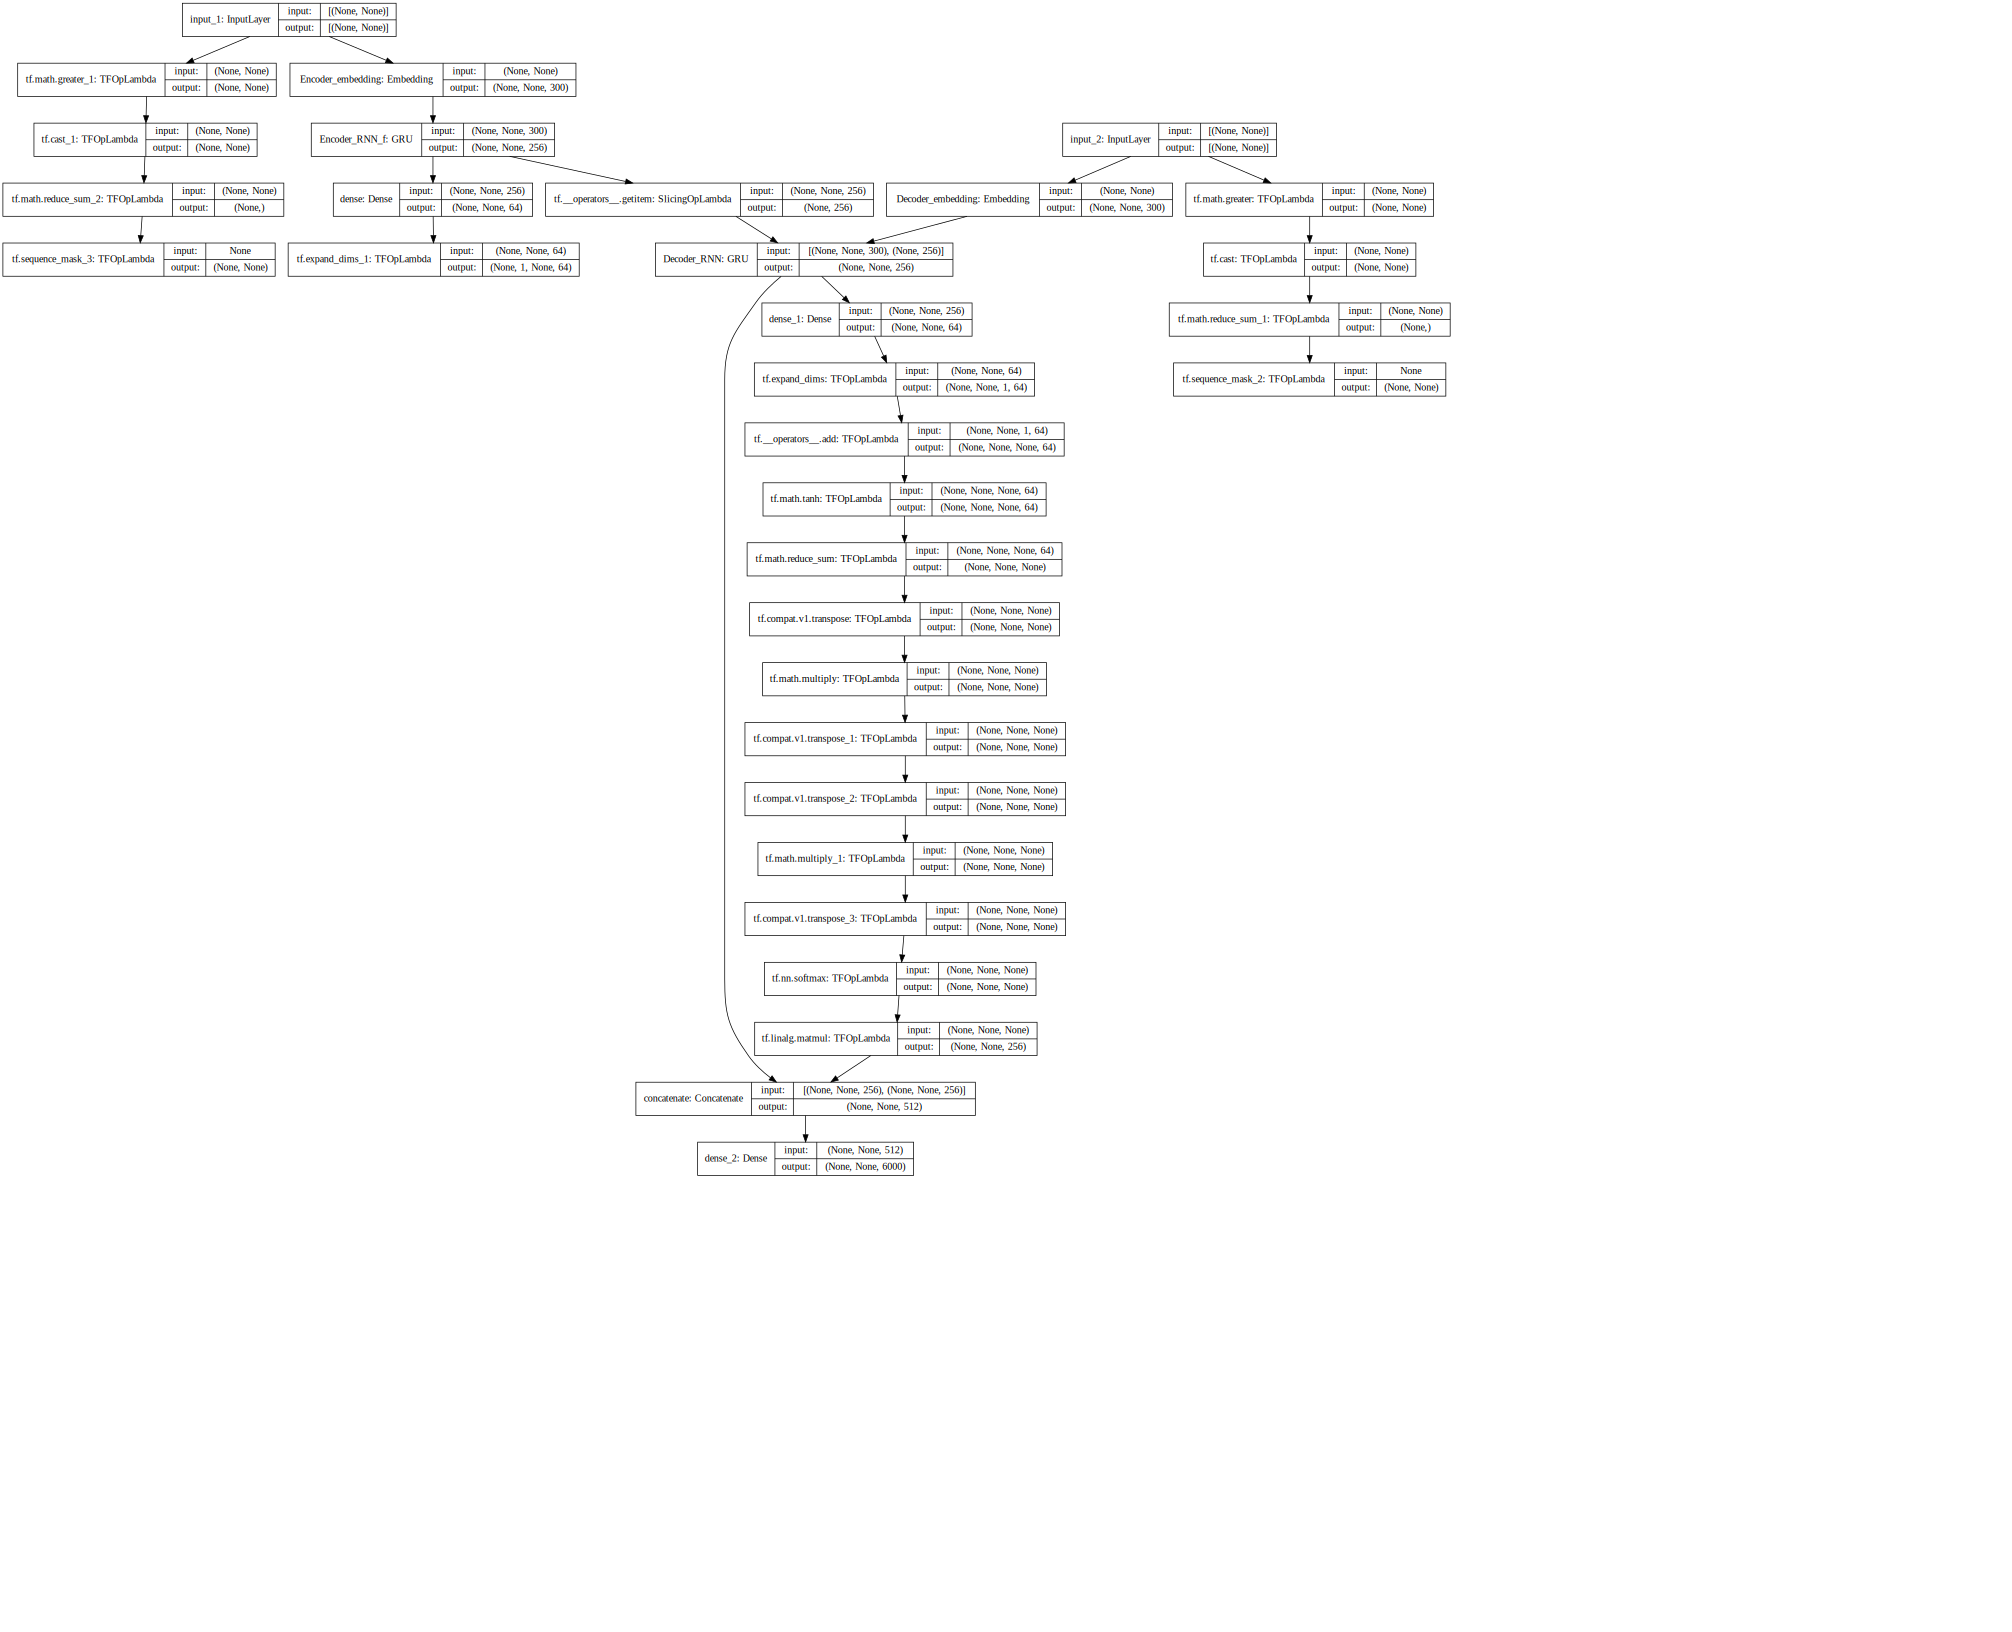

In [76]:
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model2,  show_shapes=True, show_layer_names=True, dpi=52, rankdir='TB').create_svg())

In [ ]:
hitory=model.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
472/472 [==============================] - 182s 334ms/step - loss: 1.2355 - accuracy: 0.2815
Epoch 2/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2310 - accuracy: 0.2829
Epoch 3/20
472/472 [==============================] - 158s 334ms/step - loss: 1.2266 - accuracy: 0.2842
Epoch 4/20
472/472 [==============================] - 158s 334ms/step - loss: 1.2221 - accuracy: 0.2857
Epoch 5/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2180 - accuracy: 0.2870
Epoch 6/20
472/472 [==============================] - 158s 336ms/step - loss: 1.2138 - accuracy: 0.2879
Epoch 7/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2096 - accuracy: 0.2892
Epoch 8/20
472/472 [==============================] - 158s 335ms/step - loss: 1.2059 - accuracy: 0.2904
Epoch 9/20
472/472 [==============================] - 155s 329ms/step - loss: 1.2018 - accuracy: 0.2917
Epoch 10/20
472/472 [==============================] - 155s 328m

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/baseline1.h5')

In [32]:
from keras.models import load_model
model=load_model('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/baseline1.h5')

In [33]:
embed_weights=model.get_layer(index=0).get_weights()[0]

In [ ]:
list_of_sentence[100]

'the album was preceded by two of its singles run the world girls and best thing i never had which both attained moderate success.'

In [ ]:
test_input=texts_to_sequences(encode_data(list_of_sentence[100]))
test_input.append(2)
test_input=[1]+test_input
test_1=test_input[:10]
test_1=[test_1]

In [ ]:
print([idx2word[i] for i in test_1[0]])

['<s>', '▁the', '▁album', '▁was', '▁preced', 'ed', '▁by', '▁two', '▁of', '▁its', '▁own', '▁songs', '▁and', '▁the', '▁first', '▁of', '▁the', '▁first', '▁time', '.', '</s>', 'er', "'", 's', '▁first', '▁album', '▁was', '▁released', '▁in', '▁197']


In [ ]:
for i in range(20):
  out=model.predict(test_1)
  tok=np.argmax(out[:,-1,:],axis=-1)[0]
  print(idx2word[tok])
  test_1[0].append(tok)

▁own
▁songs
▁and
▁the
▁first
▁of
▁the
▁first
▁time
.
</s>
er
'
s
▁first
▁album
▁was
▁released
▁in
▁197


In [ ]:
print([idx2word[i] for i in test_1[0]])

['<s>', '▁the', '▁album', '▁was', '▁preced', 'ed', '▁by', '▁two', '▁of', '▁its', '▁own', '▁songs', '▁and', '▁the', '▁first', '▁of', '▁the', '▁first', '▁time', '.', '</s>', 'er', "'", 's', '▁first', '▁album', '▁was', '▁released', '▁in', '▁197']


In [ ]:
df.head()

,Id,title,context,question,ans_start,text
0,56be85543aeaaa14008c9063,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce start becoming popular?,269,in the late 1990s
1,56be85543aeaaa14008c9065,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,What areas did Beyonce compete in when she was...,207,singing and dancing
2,56be85543aeaaa14008c9066,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,When did Beyonce leave Destiny's Child and bec...,526,2003
3,56bf6b0f3aeaaa14008c9601,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In what city and state did Beyonce grow up?,166,"Houston, Texas"
4,56bf6b0f3aeaaa14008c9602,Beyoncé,Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ b...,In which decade did Beyonce become famous?,276,late 1990s


In [34]:
question_set=df.question.values
answer_set=df.text.values

In [35]:
cleaned_question=[re.sub('[^A-Za-z0-9.\' ]+','',i) for i in question_set]
cleaned_question=[i.lower() for i in question_set]
cleaned_answer=[re.sub('[^A-Za-z0-9.\' ]+','',i) for i in answer_set]
cleaned_answer=[i.lower() for i in answer_set]

In [36]:
question_tokens=[]
answer_tokens=[]
for i in cleaned_question:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2)
  tokens=[1]+tokens
  question_tokens.append(tokens)
for i in cleaned_answer:
  encoded_data=encode_data(i)
  tokens=texts_to_sequences(encoded_data)
  tokens.append(2)
  tokens=[1]+tokens
  answer_tokens.append(tokens)

In [37]:
ragged_ques = tf.ragged.constant(question_tokens)
ragged_ans= tf.ragged.constant(answer_tokens)

In [38]:
def process(ques, ans):
    in_ans  = ans[:,:-1]
    out_ans = ans[:,1:]
    
    in_ques  = ques.to_tensor(default_value=0, shape=[None, None])
    in_ans  = in_ans.to_tensor(default_value=0, shape=[None, None])
    out_ans = out_ans.to_tensor(default_value=0, shape=[None, None])
    
    return (in_ques, in_ans), out_ans
dataset = tf.data.Dataset.from_tensor_slices((ragged_ques, ragged_ans))

# Specify the batch size 
dataset = dataset.batch(256)

# Use the .map() on the helper function defined above
dataset = dataset.map(process, num_parallel_calls=4)
dataset = dataset.prefetch(1)

In [39]:
tf.keras.backend.clear_session()

inputs_ques = tf.keras.Input(shape=[None])
inputs_ans = tf.keras.Input(shape=[None])

emb_eng = tf.keras.layers.Embedding(input_dim=6000, 
                                    output_dim = 300,
                                    weights=[embed_weights],
                                    mask_zero=True,
                                    trainable=False,
                                    name='Encoder_embedding')
emb_out=emb_eng(inputs_ques)
encoder_rnn = tf.keras.layers.GRU(256, return_sequences=True, name='Encoder_RNN_f')
encoder_states = encoder_rnn(emb_out)

                                    
last_encoder_state = encoder_states[:,-1,:]

# Decoder
emb_ans = tf.keras.layers.Embedding(input_dim=6000, 
                                    output_dim = 300,
                                    weights=[embed_weights],
                                    mask_zero=True,
                                    trainable=False,
                                    name='Decoder_embedding')(inputs_ans)


decoder_rnn = tf.keras.layers.GRU(256, return_sequences=True,  name='Decoder_RNN')
decoder_states = decoder_rnn(emb_ans, initial_state=last_encoder_state)

In [ ]:
hidden_size=64

dense_projection_e = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)
dense_projection_d = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)

r_encoder = dense_projection_e(encoder_states)
r_decoder = dense_projection_d(decoder_states)

In [ ]:
# Step 1:
# Expand the dimensions for the query and the value at the appropriate locations 
query = tf.expand_dims(r_decoder, axis=2)
value = tf.expand_dims(r_encoder, axis=1)


# Step 2:
# #Compute the score as in Bahdanau's paper  
score = tf.reduce_sum(tf.tanh(query + value, name='Score'), axis=-1)


# Additional step:
# It is crucial to manually mask the 'padded' hidden states otherwise there will be a mismatch between the encoder-decoder model defined above
# And the attention weights computed below 
N_query = tf.reduce_sum(tf.cast(inputs_ans>0, tf.float32), axis=1)
query_mask = tf.sequence_mask(N_query)

N_value = tf.reduce_sum(tf.cast(inputs_ques>0, tf.float32), axis=1)
value_mask = tf.sequence_mask(N_value)
# # Mask the score
m1 = tf.sequence_mask(N_query, dtype=tf.float32)
m2 = tf.sequence_mask(N_value, dtype=tf.float32)

score = tf.transpose(tf.multiply(tf.transpose(score,[2,0,1]), m1),[1,2,0])
score = tf.transpose(tf.multiply(tf.transpose(score,[1,0,2]), m2), [1,0,2])

# Step 3: Use the scores to get a distribution of probabilities
# Hint: Use softmax 
weights = tf.nn.softmax(score, axis=2, name='Weights')

# Step 4: Get the context vector by multiplying the encoder states with the weights 
# # Compute the context
context_vector = tf.matmul(weights, encoder_states)

In [ ]:
enhanced_encoding = tf.keras.layers.Concatenate(axis=2)([context_vector, decoder_states])

# Pass the enhanced encoding to a dense layer with softmax activation 
output_ans = tf.keras.layers.Dense(6000,activation='softmax')(enhanced_encoding)


# Set up the model with appropriate inputs and the output defined above 
model2 = tf.keras.Model(inputs=(inputs_ques, inputs_ans), outputs=output_ans)

# Choose an appropriate learning rate and optimizer
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [41]:
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_embedding (Embedding)   (None, None, 300)    1800000     input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
Encoder_RNN_f (GRU)             (None, None, 256)    428544      Encoder_embedding[0][0]          
______________________________________________________________________________________________

In [58]:
history2=model2.fit(dataset,epochs=20,verbose=1)

Epoch 1/20
340/340 [==============================] - 22s 65ms/step - loss: 0.4404
Epoch 2/20
340/340 [==============================] - 22s 65ms/step - loss: 0.4347
Epoch 3/20
340/340 [==============================] - 23s 66ms/step - loss: 0.4291
Epoch 4/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4246
Epoch 5/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4216
Epoch 6/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4171
Epoch 7/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4128
Epoch 8/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4093
Epoch 9/20
340/340 [==============================] - 23s 68ms/step - loss: 0.4069
Epoch 10/20
340/340 [==============================] - 23s 67ms/step - loss: 0.4035
Epoch 11/20
340/340 [==============================] - 23s 68ms/step - loss: 0.4010
Epoch 12/20
340/340 [==============================] - 23s 69ms/step - loss: 0.4024
E

In [ ]:
test_ques=df.question.iloc[15]
test_ques=texts_to_sequences(encode_data(test_ques))
test_ques.append(2)
test_ques=[1]+test_ques
test_ques=[test_ques]

In [ ]:
print([idx2word[i] for i in test_ques[0]])

['<s>', '▁', '<unk>', 'f', 'ter', '▁her', '▁second', '▁sol', 'o', '▁album', '<unk>', '▁what', '▁other', '▁entertainment', '▁vent', 'ure', '▁did', '▁', '<unk>', 'ey', 'once', '▁expl', 'ore', '<unk>', '</s>']


In [43]:
model2.save('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/encode.h5')

In [40]:
from keras.models import load_model
model2=load_model('/content/drive/MyDrive/Colab Notebooks/UNIV-AI-AI3/encode.h5')

In [60]:
def evaluate(test_ques):
  print(test_ques)
  sentence = texts_to_sequences(encode_data(test_ques))
  START_TOKEN=[word2idx['<s>']]
  END_TOKEN=[word2idx['</s>']]
  sentence = tf.expand_dims(
      START_TOKEN + sentence + END_TOKEN, axis=0)
  output = tf.expand_dims(START_TOKEN, 0)
  for i in range(20):
    predictions = model2(inputs=[sentence, output], training=False)
    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # concatenated the predicted_id to the output which is given to the decoder as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0)

def predict(sentence):
  prediction = evaluate(sentence)
  predicted_sentence = [idx2word[i] for i in prediction.numpy()]
  return predicted_sentence

In [61]:
for i in range(0,100,5):
  print(predict(df.question.iloc[i]))
  print(df.text.iloc[i])

When did Beyonce start becoming popular?
['<s>', '▁n', '<unk>', 's', '▁n', 'ied', 'er', 'ts']
in the late 1990s
In what R&B group was she the lead singer?
['<s>', '▁african', '▁american', '▁tribes']
Destiny's Child
What was the first album Beyoncé released as a solo artist?
['<s>', '▁the', '▁tr', 'ips']
Dangerously in Love
After her second solo album, what other entertainment venture did Beyonce explore?
['<s>', '▁inf', 'in', 'ite']
acting
Which album was darker in tone from her previous work?
['<s>', '▁aristot', 'ians']
Beyoncé
Who is Beyoncé married to?
['<s>', '▁engine', 'er']
Jay Z
In which decade did the Recording Industry Association of America recognize Beyonce as the The Top Certified Artist?
['<s>', '▁early', '▁1990', 's']
2000s
How many records did Beyoncé sell as part of Destiny's Child?
['<s>', '▁the', '▁su', 'e', 'z', '▁canal']
60 million
Where did Beyonce get her name from?
['<s>', '▁to', '▁use', '▁a', '▁th', 'ing', '<unk>', '▁sal', 't', '<unk>', 'day', '▁his', '▁case']
h